# Facial Expression Image Generation using GAN



In [14]:
import tensorflow as tf

import os
import time
from os import path
from matplotlib import pyplot as plt

import datetime
import numpy as np
import pathlib
import random

## Loading Model

In [15]:
#!pip install gdown

In [16]:
import gdown
encoder_url = "https://drive.google.com/uc?id=1ZkxRWBgm6hwmMasuLWUgpAfW9uiAmsIY"
decoder_url = "https://drive.google.com/uc?id=1R79d61-1ffkAVgJ4MQUQ70ki1PVJpvkh"
model_url = "https://drive.google.com/uc?id=1cXvfMRm0yGkMbulkO6jRgwku56Vg32sR"

gdown.download(encoder_url,'encoder.h5',quiet=False)
gdown.download(decoder_url,'decoder.h5',quiet=False)

gdown.download(model_url,'generator.h5',quiet=False)


Downloading...
From: https://drive.google.com/uc?id=1ZkxRWBgm6hwmMasuLWUgpAfW9uiAmsIY
To: /content/encoder.h5
100%|██████████| 65.8M/65.8M [00:00<00:00, 126MB/s]
Downloading...
From: https://drive.google.com/uc?id=1R79d61-1ffkAVgJ4MQUQ70ki1PVJpvkh
To: /content/decoder.h5
100%|██████████| 77.9M/77.9M [00:00<00:00, 179MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1cXvfMRm0yGkMbulkO6jRgwku56Vg32sR
From (redirected): https://drive.google.com/uc?id=1cXvfMRm0yGkMbulkO6jRgwku56Vg32sR&confirm=t&uuid=6fc2696d-33f2-4a4f-b0a3-d486a9cff19b
To: /content/generator.h5
100%|██████████| 144M/144M [00:01<00:00, 130MB/s]


'generator.h5'

In [17]:
encoder = tf.keras.models.load_model("encoder.h5")
decoder = tf.keras.models.load_model("decoder.h5")

encoder.summary()
decoder.summary()
generator = tf.keras.models.load_model("generator.h5")
generator.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 label_input (InputLayer)    [(None, 7)]                  0         []                            
                                                                                                  
 dense (Dense)               (None, 16384)                131072    ['label_input[0][0]']         
                                                                                                  
 img_input (InputLayer)      [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 reshape (Reshape)           (None, 128, 128, 1)          0         ['dense[0][0]']               
                                                                                              

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 label_input (InputLayer)    [(None, 7)]                  0         []                            
                                                                                                  
 dense (Dense)               (None, 16384)                131072    ['label_input[0][0]']         
                                                                                                  
 img_input (InputLayer)      [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 reshape (Reshape)           (None, 128, 128, 1)          0         ['dense[0][0]']               
                                                                                            

## Results

## Using only decoder to generate random samples

1/1 [==============================] - 0s 458ms/step


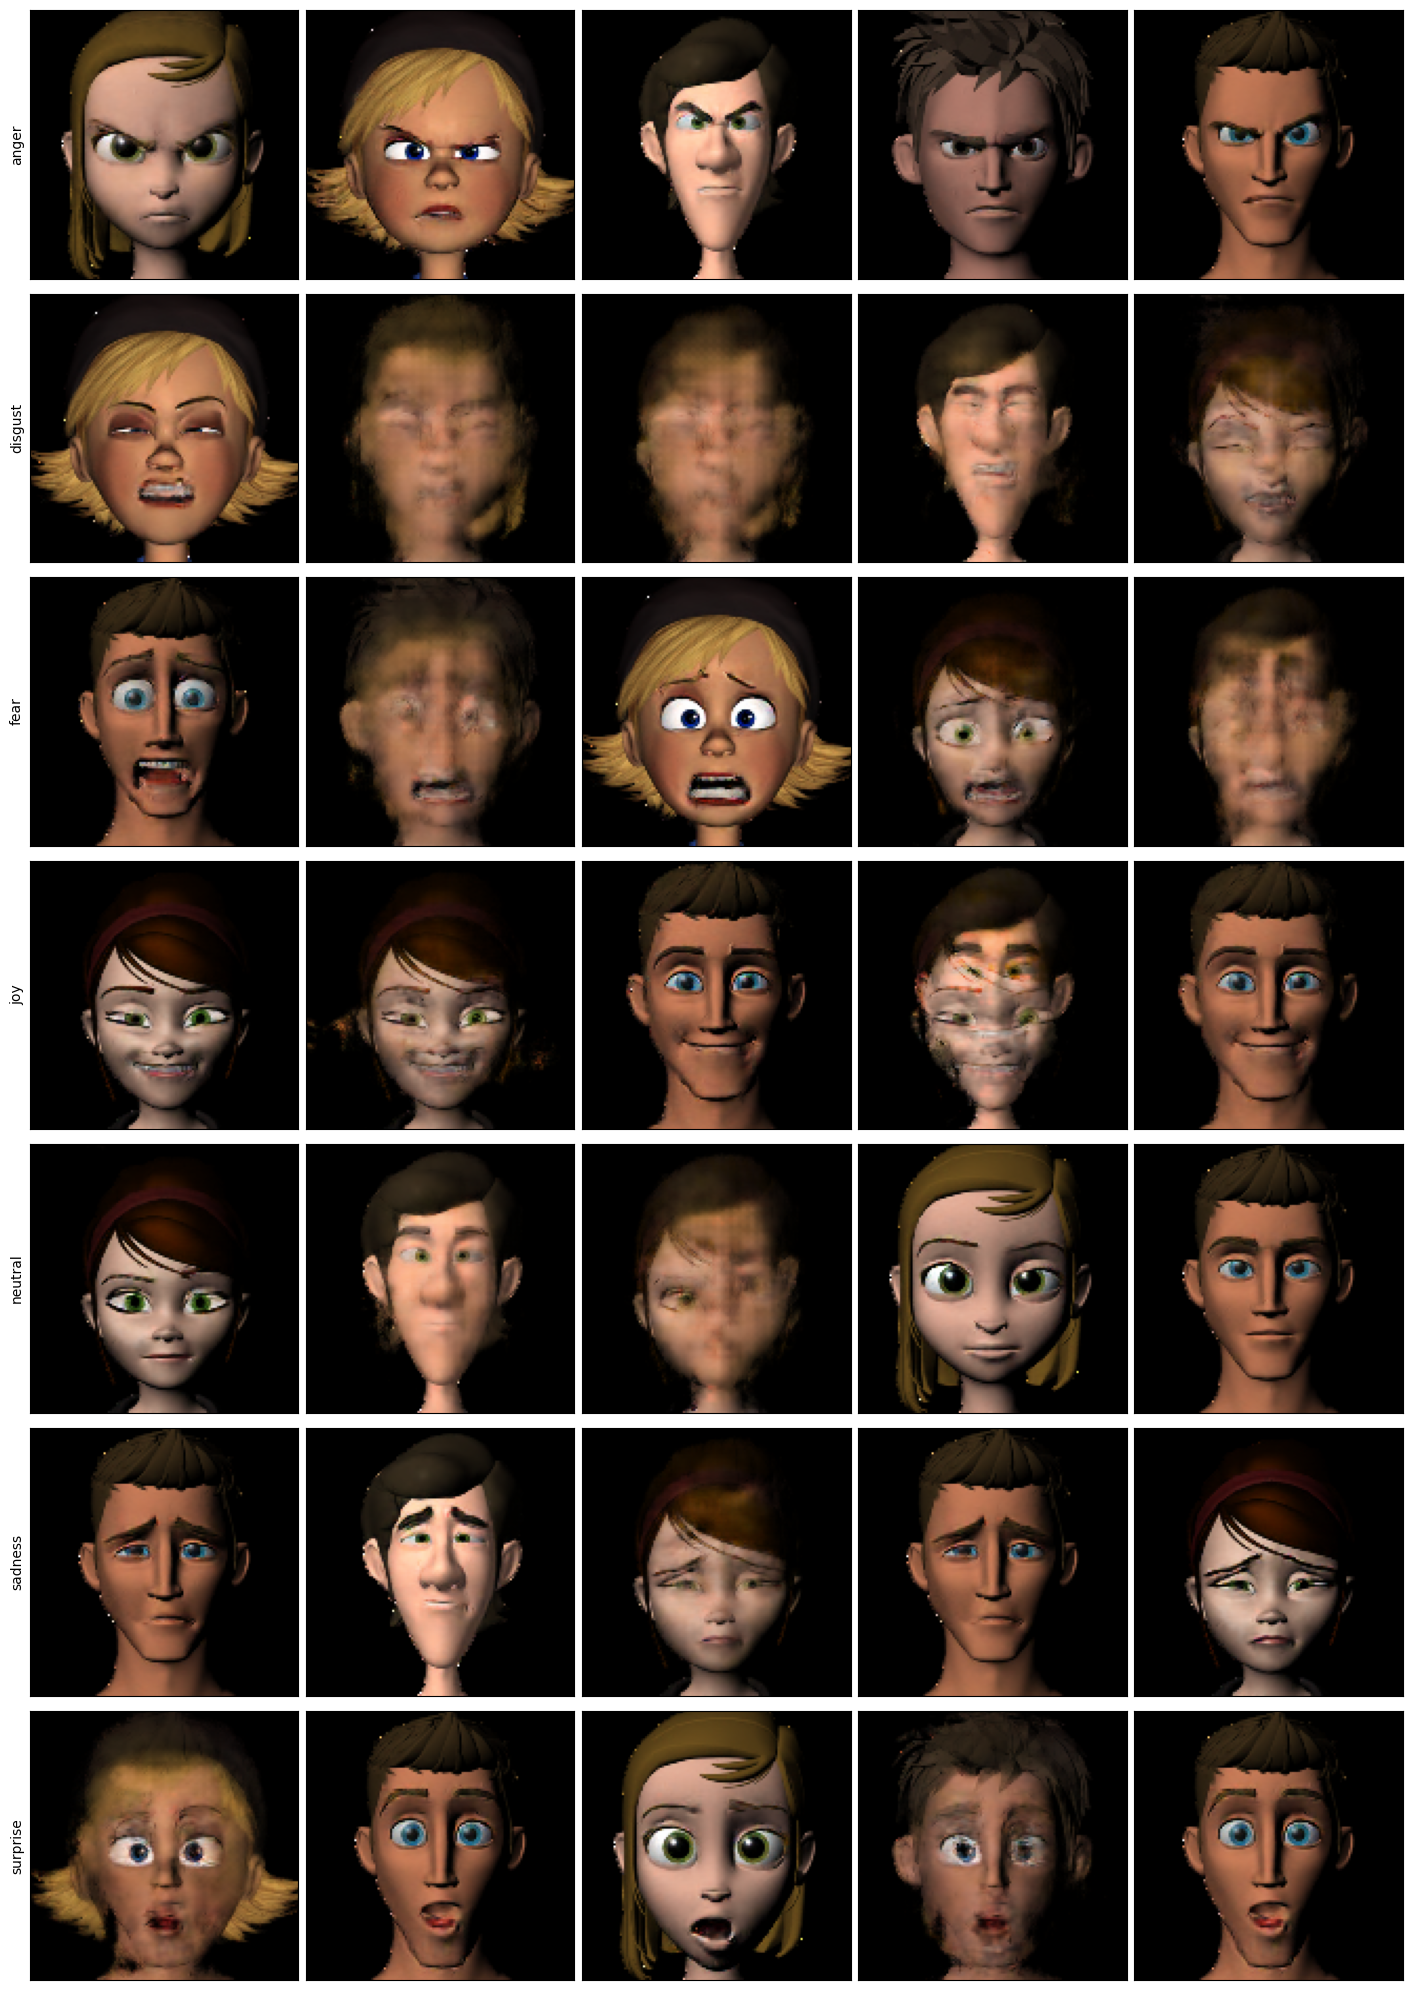

In [18]:
latent_dim = 128
affects = ["anger","disgust","fear","joy","neutral","sadness","surprise"]

fig = plt.figure(figsize=(15, 20))

fig.subplots_adjust(left=0.01, right=0.99,  wspace=0.01)

for i in range(7):
    latent_space = np.random.normal(0, 1, (5, latent_dim))
    lbl = np.zeros(shape=(5,7))
    lbl[:,i] = np.random.normal(0,1)
    fake = decoder.predict([latent_space,lbl])
    for j in range(5):

        ax = fig.add_subplot(7,5, 5*i+j+1)
        img = (0.5*fake[j,:,:,:]+0.5)
        img = np.array(img)
        ax.imshow(img)
        ax.set_yticks([])
        ax.set_xticks([])
        if(j==0):
            ax.set_ylabel(affects[i])
fig.tight_layout()

In [19]:
import glob
def load_test_images(img_dir,affect_idx):
    img_files = sorted(glob.glob(img_dir+"/*.png"))
    latent_vecs = []
    conditions = []
    imgs = []
    for img_file in img_files:

        img = tf.io.read_file(img_file)
        img =  tf.image.decode_png(img,channels=3)
        imgs.append(img)
        img = tf.cast(img, tf.float32)
        img = (img / 127.5) - 1
        img = tf.reshape(img,shape=(1,128,128,3))
        lbl  = np.zeros(7)
        lbl[affect_idx] = 1
        lbl = tf.reshape(lbl,shape=(1,7))
        latent_vec,mu,sigma = encoder.predict([img,lbl])
        conditions.append(lbl)
        latent_vecs.append(mu)
    return imgs,latent_vecs,conditions

In [ ]:
import gdown
import zipfile
gdown.download('https://github.com/vedanthv/face-emotion-recognition/tree/main/experiments/gan_image_generation/test.zip','test.zip',quiet=False)
!unzip test

Downloading...
From: https://github.com/azadlab/FExGAN/test.tar
To: D:\projs\Research\Code\DeepCV\publications\FExGAN_Demo\test.tar
 22%|███████████████████▌                                                                   | 9.00/40.0 [00:00<?, ?B/s]
'untar' is not recognized as an internal or external command,
operable program or batch file.


## Generating Affect Images from Neutral Image input and a desired Affect Condition

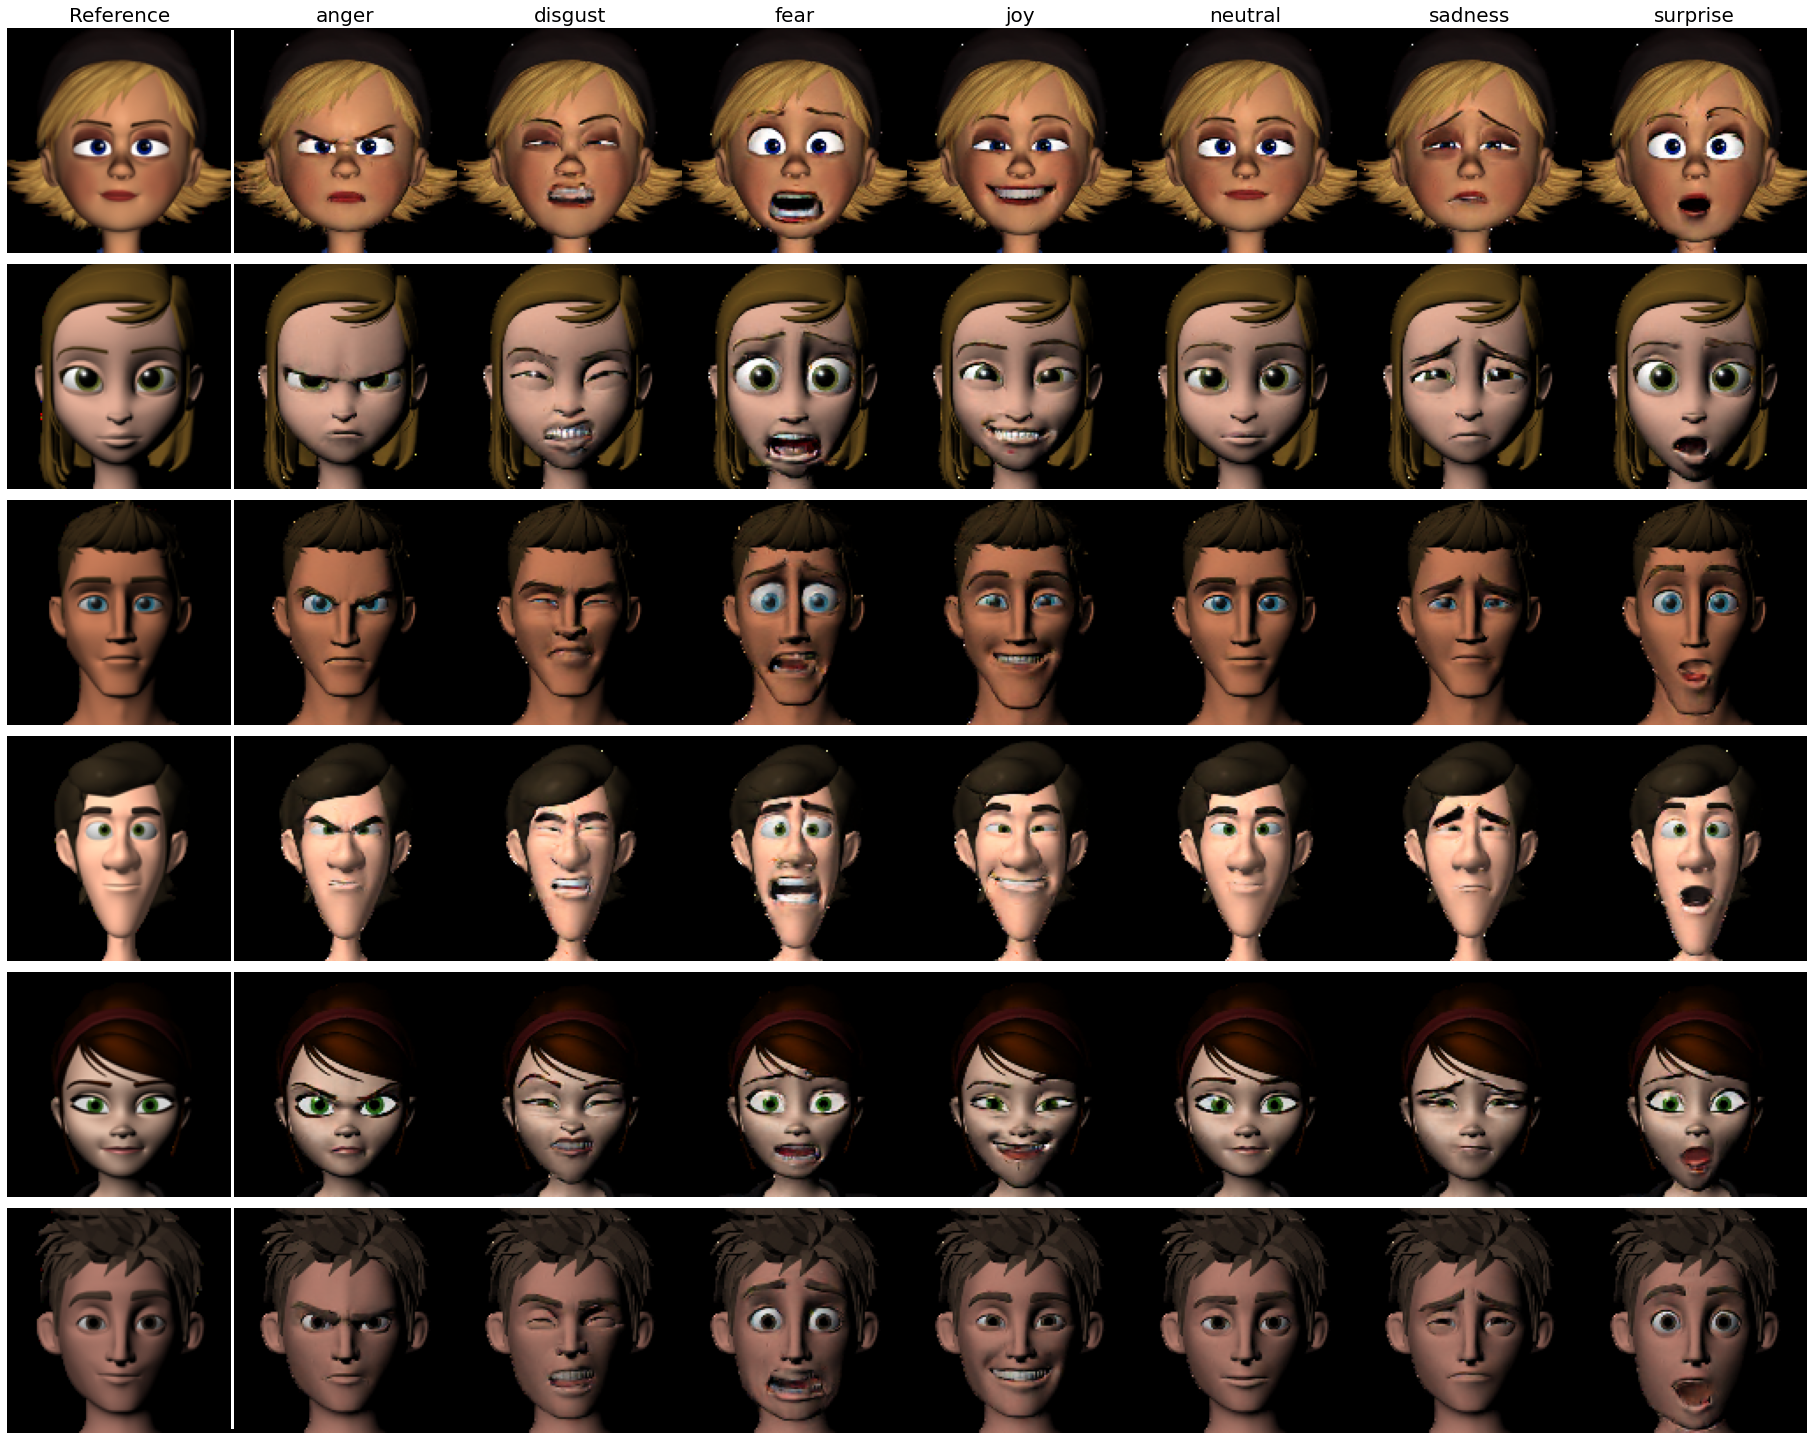

In [ ]:
ref_imgs,latent_vecs,conditions = load_test_images("test/neutral",4)

fig, axes = plt.subplots(6, 8,figsize=(25,20))


for k,ref_img,mu,condition in zip(range(0,6),ref_imgs,latent_vecs,conditions):
    ax = axes[k][0]
    ax.imshow(ref_img)

    if(k==0):
        ax.set_title("Reference", fontsize=20)
    ax.axis('off')
    for i in range(1,8):
            lbl  = np.zeros(7)
            lbl[i-1] = 1
            lbl = lbl.reshape((1,7))
            fake = decoder.predict([mu,lbl])
            fake = tf.reshape(fake,shape=(128,128,3))
            fake = (0.5*fake+0.5)
            ax = axes[k][i]
            ax.imshow(fake)
            ax.axis('off')
            if(k==0):
                ax.set_title(affects[i-1], fontsize=20)
line = plt.Line2D((.125,.125),(0.01,.98), color="w", linewidth=3)
fig.add_artist(line)
fig.tight_layout(pad=0, w_pad=0, h_pad=0)

## Generating Mixed Expressions

In [ ]:
ref_imgs,latent_vecs,conditions = load_test_images("test/neutral",4)


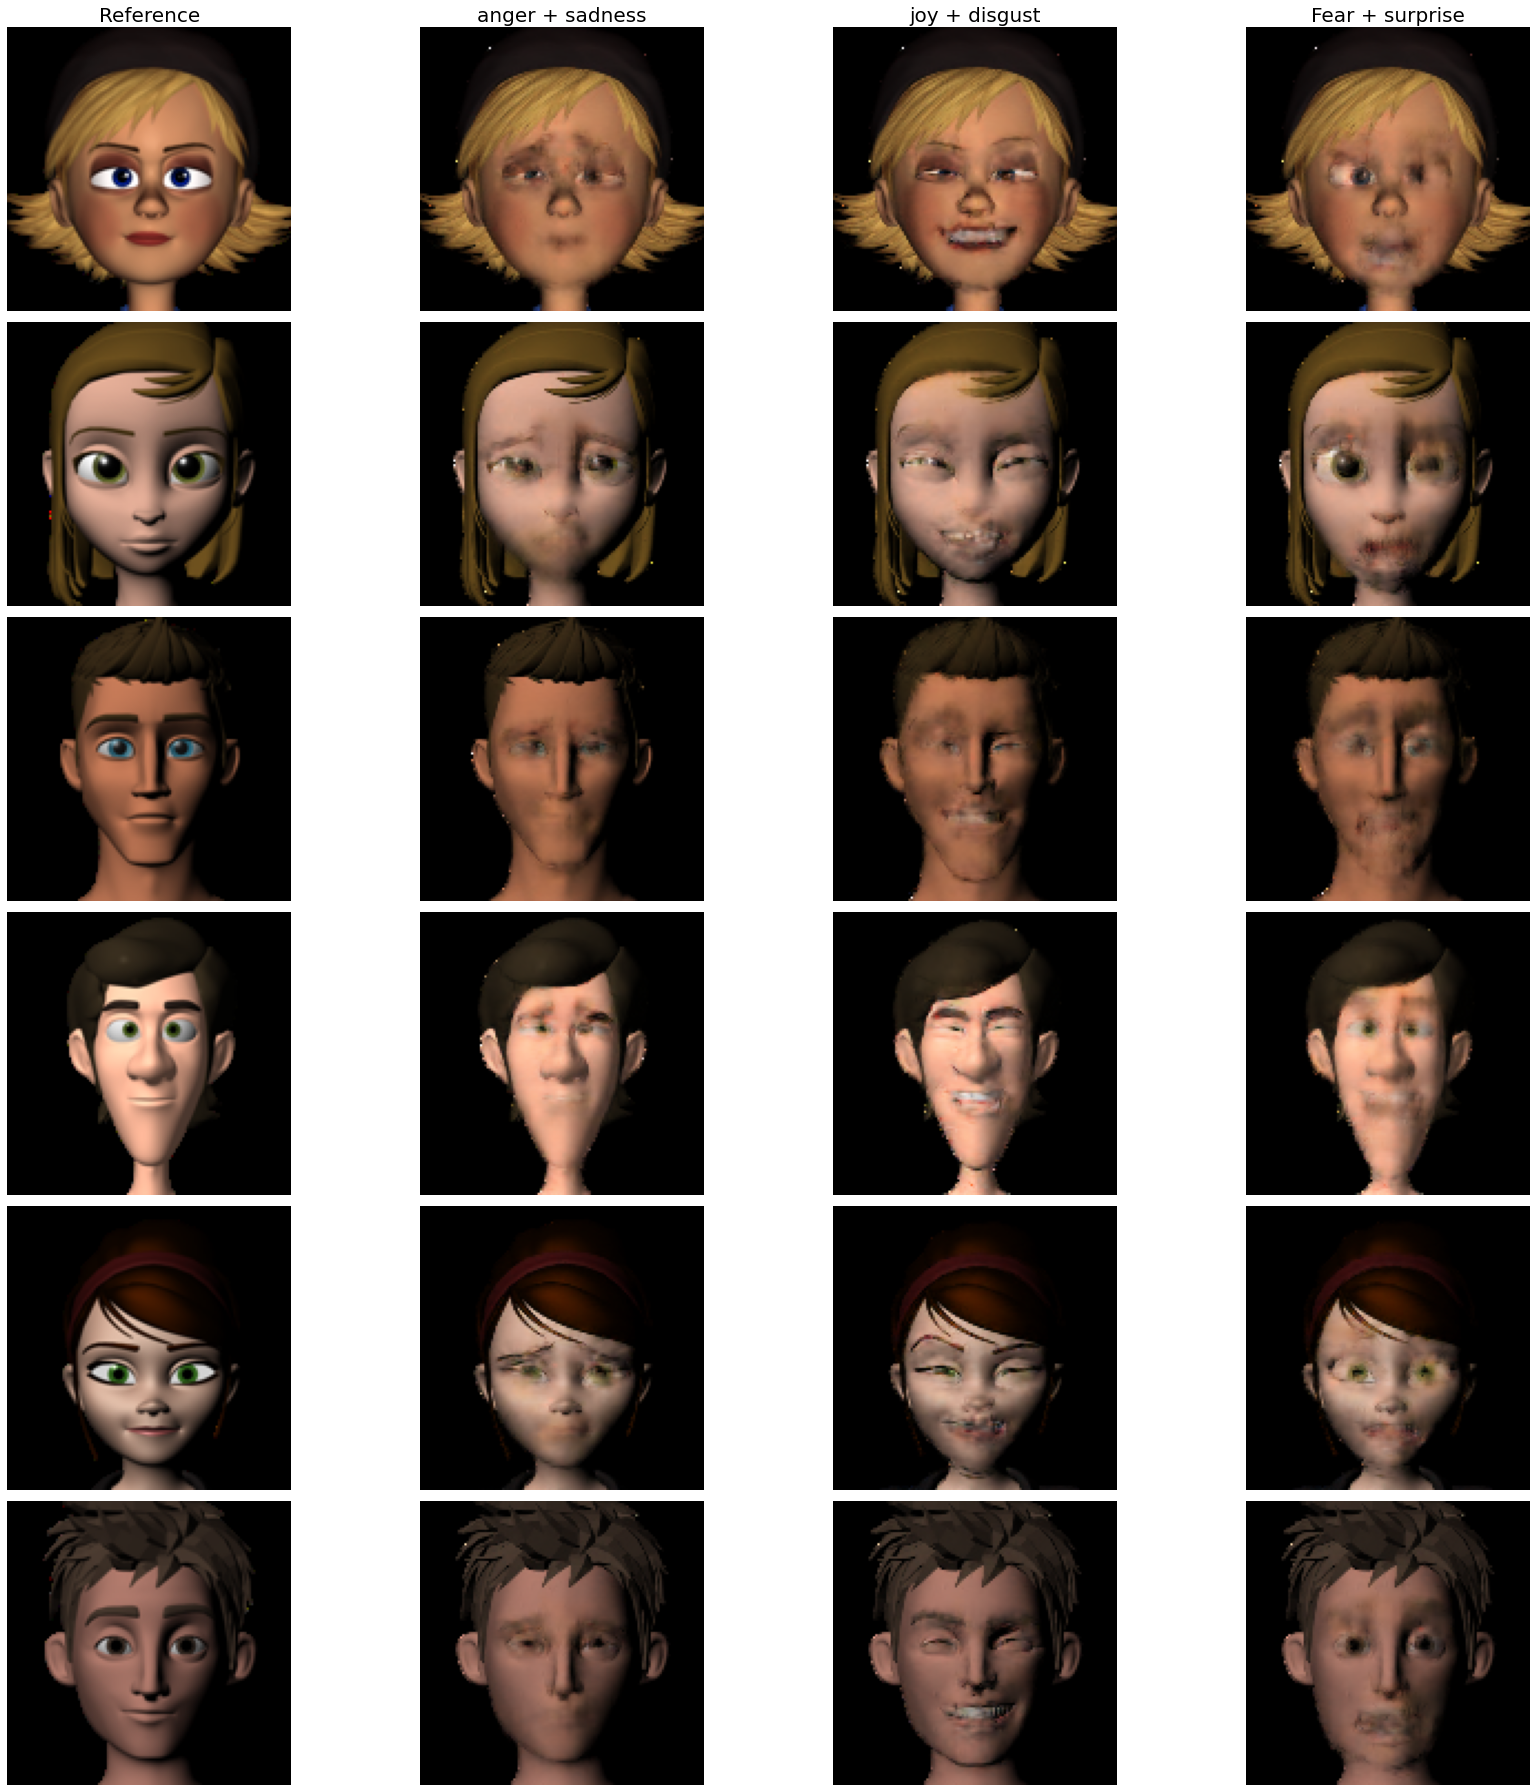

In [ ]:
fig, axes = plt.subplots(6, 4,figsize=(25,25))
fig.subplots_adjust(wspace=0.01, hspace=0.1)
mixed_affects = ["anger + sadness","joy + disgust","Fear + surprise"]

lbls  = np.zeros(shape=(3,7))
lbls[0,:] = [0.6,0,0,0,0,0.7,0]   #anger + sadness
lbls[1,:] = [0,0.8,0,1,0,0,0]   #joy + disgust
lbls[2,:] = [0,0,0.8,0,0,0,0.75]   #Fear + surprise


for k,ref_img,mu,condition in zip(range(0,6),ref_imgs,latent_vecs,conditions):
    ax = axes[k][0]
    ax.imshow(ref_img)

    if(k==0):
        ax.set_title("Reference", fontsize=20)
    ax.axis('off')
    for i in range(1,4):
            lbl = lbls[i-1,:]
            lbl = lbl.reshape((1,7))

            fake = decoder.predict([mu,lbl])
            fake = tf.reshape(fake,shape=(128,128,3))
            fake = (0.5*fake+0.5)
            ax = axes[k][i]
            ax.imshow(fake)
            ax.axis('off')
            if(k==0):
                ax.set_title(mixed_affects[i-1], fontsize=20)
fig.tight_layout()


# Mixed Expressions using two reference expressions

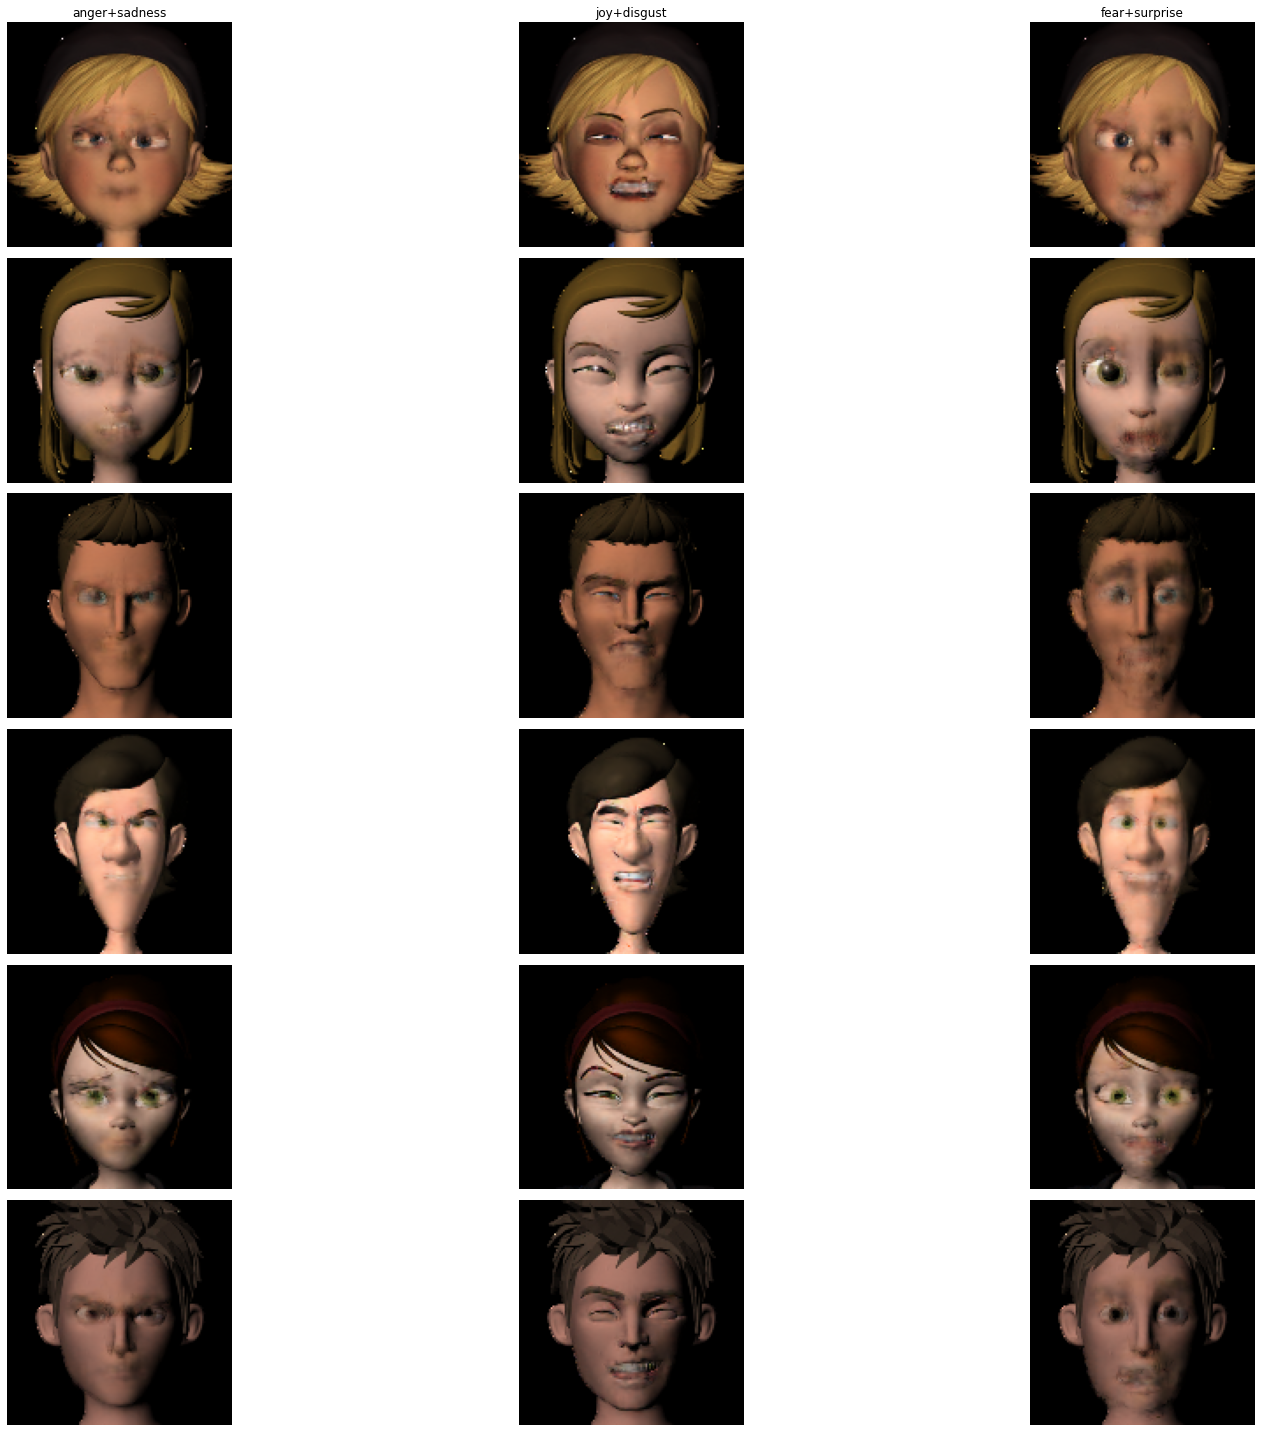

In [ ]:
fig, axes = plt.subplots(6, 3,figsize=(25,20))

char_latents = []
char_conditions = []
for affect_idx in range(0,7):
        imgs,latent_vecs,conditions = load_test_images("test/"+affects[affect_idx],affect_idx)
        char_latents.append(latent_vecs)
        char_conditions.append(conditions)




for i in range(6):
    # Anger + sadness
    latents_anger_sadness = (char_latents[0][i] + char_latents[5][i])/2
    conditions_anger_sadness = (char_conditions[0][i] + char_conditions[5][i])/2
    fake = decoder.predict([latents_anger_sadness,conditions_anger_sadness])
    fake = tf.reshape(fake,shape=(128,128,3))
    fake = (0.5*fake+0.5)
    ax = axes[i][0]
    ax.imshow(fake)
    if(i==0):
        ax.set_title("anger+sadness")
    ax.axis('off')


    # joy + disgust
    latents_anger_sadness = (char_latents[1][i] + char_latents[3][i])/2
    conditions_anger_sadness = (char_conditions[1][i] + char_conditions[3][i])/2
    fake = decoder.predict([latents_anger_sadness,conditions_anger_sadness])
    fake = tf.reshape(fake,shape=(128,128,3))
    fake = (0.5*fake+0.5)
    ax = axes[i][1]
    ax.imshow(fake)
    if(i==0):
        ax.set_title("joy+disgust")
    ax.axis('off')

    # fear + surprise
    latents_anger_sadness = (char_latents[2][i] + char_latents[6][i])/2
    conditions_anger_sadness = (char_conditions[2][i] + char_conditions[6][i])/2
    fake = decoder.predict([latents_anger_sadness,conditions_anger_sadness])
    fake = tf.reshape(fake,shape=(128,128,3))
    fake = (0.5*fake+0.5)
    ax = axes[i][2]
    ax.imshow(fake)
    if(i==0):
        ax.set_title("fear+surprise")
    ax.axis('off')
fig.tight_layout()

## Animation


In [ ]:
from PIL import Image

affect_variation = np.linspace(-1,1,100)
imgs = []
src_idx = 4
lbl  = np.zeros(7)
lbl[src_idx] = 1

for tar_idx in range(7):

    for k in range(10):
        big_img = np.zeros((128,768,3))
        lbl[tar_idx] += 0.1
        lbl[src_idx] -= 0.1
        affect = lbl.reshape((1,7))
        for i,mu in zip(range(len(latent_vecs)),latent_vecs):

                pred = decoder.predict([mu,affect])
                img = tf.reshape(pred,shape=(128,128,3))
                img = (0.5*img+0.5)
                big_img[:,i*128:i*128+128,:] = img
        imgs.append(Image.fromarray(np.uint8(big_img*255)).convert("P",palette=Image.ADAPTIVE))
    src_idx = tar_idx